# Figure 3g

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from requirements import *
from segger.data.parquet._utils import (
    filter_transcripts,
    load_settings,
)
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import preprocess_rapids
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.plot_volcano import plot_volcano
import anndata

In [283]:
seg_col = 'baysor_cell_id_c=0.5'

In [284]:
# Read in AnnData
filepath = data_dir / f'h5ads/{seg_col}.h5ad'
ad = sc.read_h5ad(filepath)

In [288]:
# Subset Segger data to high-confidence transcripts
mask = np.full(transcripts.shape[0], True)
if 'segger' in seg_col:
    score_col = seg_col.replace('cell_id', 'score')
    mask &= transcripts[score_col].gt(0.5)

# Transcripts to anndata
ad = anndata_from_transcripts(
    transcripts[mask],
    cell_label=seg_col,
    gene_label='feature_name',
)

NameError: name 'transcripts' is not defined

In [280]:
ad.obs['cell_type'].value_counts() / ad.obs.shape[0]

cell_type
Epithelial/Cancer             0.455225
Fibroblast and Stromal        0.313271
Myeloid                       0.109012
Endothelial                   0.054632
Smooth Muscle and Pericyte    0.038863
Lymphoid                      0.028996
Name: count, dtype: float64

In [281]:
ad.obs.groupby('cell_type')['n_counts'].mean()

cell_type
Endothelial                    43.504327
Epithelial/Cancer             112.792786
Fibroblast and Stromal         43.127588
Lymphoid                       29.321099
Myeloid                        28.099697
Smooth Muscle and Pericyte     38.933237
Name: n_counts, dtype: float64

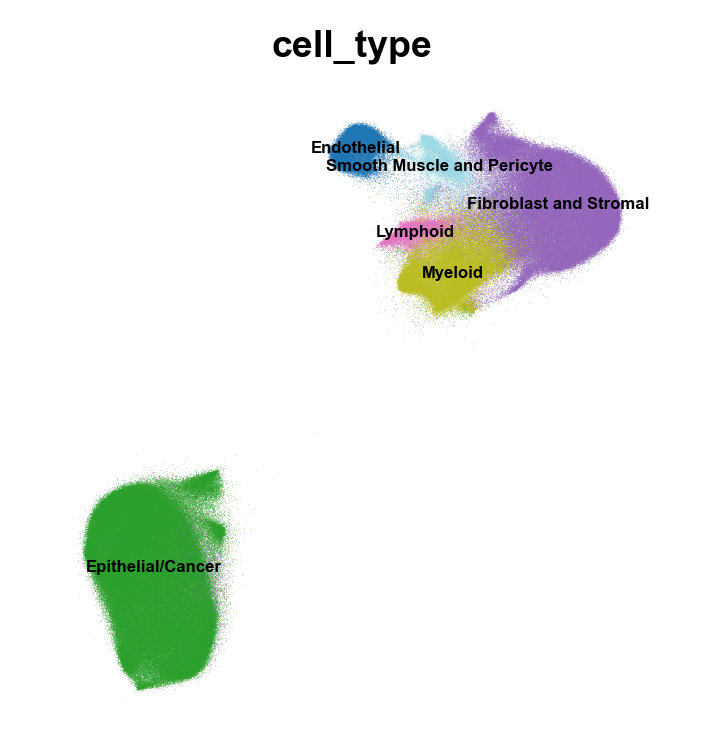

In [282]:
fig = plot_embedding(
    ad,
    'cell_type',
    basis='X_umap',
    layer='lognorm',
    legend_loc='on data',
    legend_fontsize=4,
    dim=3,
    s=0.1,
    sort_order=True,
)

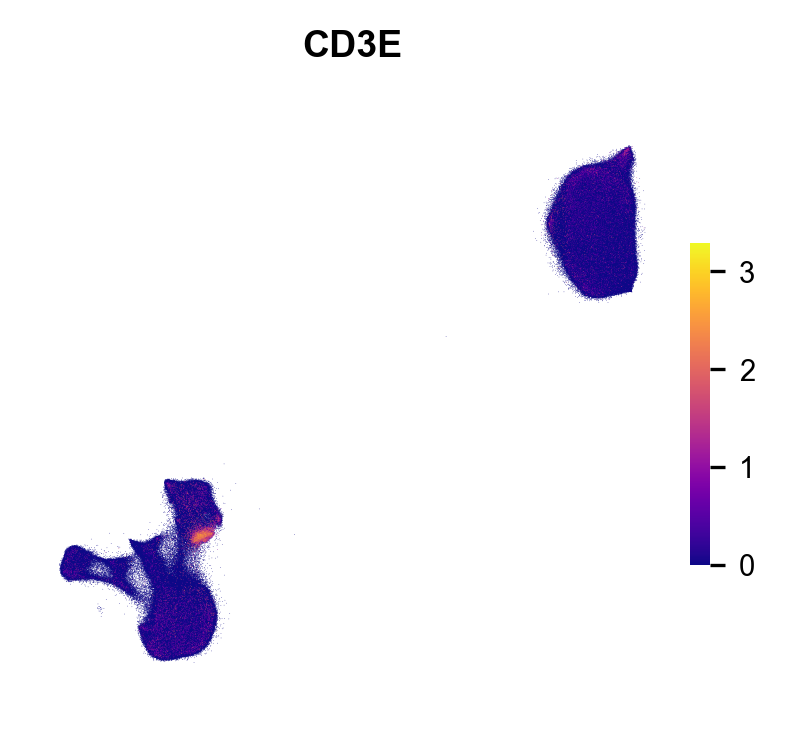

In [252]:
fig = plot_embedding(
    ad,
    'CD3E',
    basis='X_umap',
    layer='lognorm',
    legend_loc='on data',
    legend_fontsize=4,
    dim=3,
    s=0.1,
)

In [151]:
ad.obs.groupby('cell_type')['n_counts'].mean()

cell_type
Endothelial                    43.504327
Epithelial/Cancer             112.792786
Fibroblast and Stromal         43.127588
Lymphoid                       29.321099
Myeloid                        28.099697
Smooth Muscle and Pericyte     38.933237
Name: n_counts, dtype: float64

In [152]:
ad.obs['cell_type'].value_counts() / ad.obs.shape[0]

cell_type
Epithelial/Cancer             0.455225
Fibroblast and Stromal        0.313271
Myeloid                       0.109012
Endothelial                   0.054632
Smooth Muscle and Pericyte    0.038863
Lymphoid                      0.028996
Name: count, dtype: float64

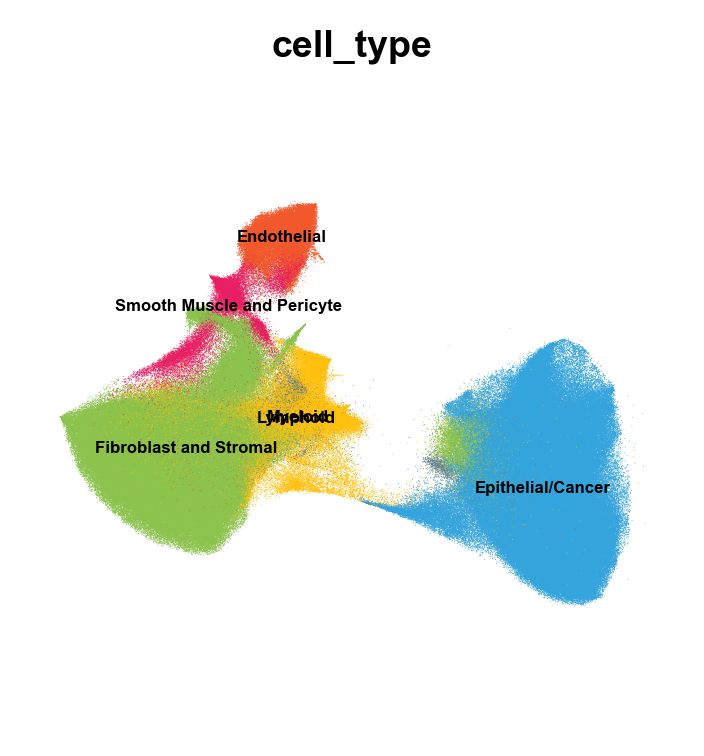

In [34]:
fig = plot_embedding(
    ad,
    'cell_type',
    basis='X_umap',
    legend_loc='on data',
    palette=named_colors,
    legend_fontsize=4,
    dim=3,
    s=0.2,
    sort_order=False,
)

## Transcripts to AnnData

*Note*: Below, I filter using 'min_counts_per_cell' = 50. 
This is fairly aggressive for Xenium data, as it removes, for instance, many 
immune cells which have lower capture levels. However, for this analysis, my
primary concern is capturing genuine epithelial cells, whose UMIs are high above
this level, and a more aggressive filtering significantly cleans the data.

In [5]:
# Read in all transcripts
transcripts = pd.read_parquet(data_dir / 'labeled_transcripts.parquet')

# Filter control probes and low QV probes
xe_settings = load_settings('xenium')
transcripts = filter_transcripts(
    transcripts,
    label=xe_settings.transcripts.label,
    filter_substrings=xe_settings.transcripts.filter_substrings,
    min_qv=30,
)

# Label epithelial transcripts
is_epithelial = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
transcripts['is_epithelial'] = is_epithelial

In [44]:
# Segmentation columns to compare
segmentation_columns = [
    '10x_cell_id',
    '10x_nucleus_id',
    'baysor_cell_id_c=0.5',
    'baysor_cell_id_c=0.9',
    'segger_cell_id_3Q6EISGCD9',
    'segger_cell_id_HDE46PBXJB',
]

In [45]:
# Build and process AnnData for each
for seg_col in segmentation_columns:

    # Filter by cellpose epithelial labels and segger score
    gb = transcripts.groupby(seg_col)
    mask = gb['is_epithelial'].mean().gt(0.5)
    mask = transcripts[seg_col].map(mask).fillna(False)
    if 'segger' in seg_col:
        mask &= transcripts[seg_col.replace('cell_id', 'score')].gt(0.33)

    # Transcripts to anndata
    ad = anndata_from_transcripts(
        transcripts[mask],
        cell_label=seg_col,
        gene_label='feature_name',
    )
    
    # Preprocess
    preprocess_rapids(
        ad,
        filter_min_counts=50,
        pca_total_var=0.75,
        pca_layer='norm',
        knn_neighbors=20,
        phenograph_resolution=0.75,
    )
    
    # Save to file
    ad.write_h5ad(data_dir / f'h5ads/{seg_col}_epithelial.h5ad')

Done: 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]         


## Contamination in Segger vs. 10X cell segmentation

In [3]:
ad_10x = sc.read_h5ad(data_dir / f'h5ads/10x_cell_id.h5ad')
ad_seg = sc.read_h5ad(data_dir / f'h5ads/segger_cell_id_HDE46PBXJB.h5ad')

In [4]:
mask = ad_seg.obs['celltypist_label'].eq('Epithelial/Cancer')
mask &= ad_seg.obs['celltypist_probability'].gt(0.5)
ad_seg = ad_seg[mask]

In [5]:
mask = ad_10x.obs['celltypist_label'].eq('Epithelial/Cancer')
mask &= ad_10x.obs['celltypist_probability'].gt(0.5)
ad_10x = ad_10x[mask]

In [20]:
ad = anndata.concat(
    [ad_seg, ad_10x],
    label='segmentation',
    keys=['segger+', '10X'],
    index_unique='-',
)

In [21]:
# Preprocess
preprocess_rapids(
    ad,
    filter_min_counts=50,
    pca_total_var=0.75,
    pca_layer='norm',
    knn_neighbors=20,
    phenograph_resolution=0.75,
)

Done: 100%|██████████| 6/6 [01:15<00:00, 12.56s/it]         


In [22]:
# Differential expression between
sc.tl.rank_genes_groups(
    ad,
    groupby='segmentation',
    use_raw=False,
    layer='lognorm',
    method='wilcoxon'
)

In [41]:
# Get top markers used for classification
import celltypist as ct
ct_model = ct.Model.load(str(data_dir / 'NSCLC_celltypist_model.pkl'))
coefs = pd.DataFrame(
    ct_model.classifier.coef_.T,
    index=ct_model.features,
    columns=ct_model.cell_types,
)
mask = coefs.max(1).gt(0.1)
mask &= coefs.apply(
    lambda x: x.nlargest(2).diff().lt(-0.).any(),
    axis=1
)
highlight = dict()
for gene, name in coefs.idxmax(1)[mask].items():
    highlight[gene] = named_colors[name]

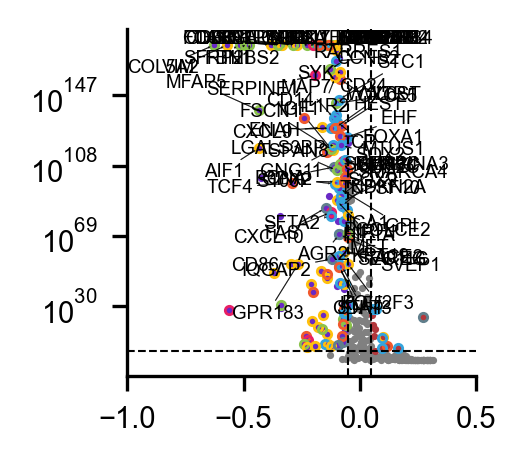

In [42]:
fig, ax = plt.subplots(1,1, figsize=(1.5, 1.5))

plot_volcano(
    ad.uns['rank_genes_groups'],
    group='segger+',
    pvals_lim=(1e-175, 1e-5),
    logfc_lim=(-1, 0.5),
    logfc_cutoff=0.05,
    ax=ax,
    palette=named_colors,
    highlight=highlight,
)

#fig.savefig(media_dir / 'figure_3g.svg')